# Pipeline - School Zone Warning Prediction

The purpose of this notebook is to execute a pipeline related to finding roads around schools and lat/lon + bearing points which will be used for gathering street-level imagery. This data in turn is used to help automatically determine the iRAP 5-star attribute code for school signage. The focus of this pipeline notebook is to first gather aerial-level data in correspondence with the focus of the project task.

Note that while this singular notebook will run a sequence of actions, not all components are used for exactly the same result. For instance, roads which do not appear within the school roads dataset do not require further analysis to determine the existence of signage.

## Parameter Data Formats

This pipeline makes use of various yaml files for source data and credentials. These files contain the following data formatting provided by example.

### pipeline_schoolroads_sources.yaml

```yaml
school_data:
    - region_schools:
        name: "usa"
        link: "http://..."
        unzip: True
        target: "EDGE_GEOCODE_PUBLICSCH_1819.xlsx"
        lat_colname: "LAT"
        lon_colname: "LON"
    - region_schools:
        name: "another_location"
        link: "http://..."
        unzip: True
        target: "some_file.xlsx"
        lat_colname: "lat"
        lon_colname: "lon" 
```

### pipeline_schoolroads_credentials.yaml

```yaml
google:
    key: "api_key_here"
```

In [1]:
import datetime
import logging
import os
import sys

import nbconvert
import nbformat
import papermill as pm
from box import Box
from prefect import Flow, Parameter, task, unmapped
from prefect.tasks.control_flow import ifelse, merge
from prefect.tasks.jupyter.jupyter import ExecuteNotebook
from prefect.utilities.tasks import defaults_from_attrs

In [2]:
@task
def school_data_to_list(param: Parameter) -> dict:
    # extract school data to list of elements needed for pipeline
    data = Box.from_yaml(filename=param)
    return data["school_data"]

In [3]:
@task
def merge_school_data_and_creds(school_data: dict, credentials: dict) -> dict:
    # merge school data list elements with credentials
    merged = school_data.copy()
    for item in merged:
        item["credentials"] = credentials.to_dict()["credentials"]
    return merged

In [4]:
# modified from Prefect src task to avoid output, for now
# ref: https://github.com/PrefectHQ/prefect/blob/12eb68a57b526e9988b90158081b946d9dfdd392/src/prefect/tasks/jupyter/jupyter.py
@task
def exe_notebook(
    path: str = None,
    parameters: dict = None,
    output_format: str = None,
    exporter_kwargs: dict = None,
    kernel_name: str = None,
    timeout=500,
    max_retries=2,
    retry_delay=datetime.timedelta(seconds=5),
) -> str:
    """
        Run a Jupyter notebook and output as HTML, notebook, or other formats.
        Args:
        - path (string, optional): path to fetch the notebook from; can also be
            a cloud storage path
        - parameters (dict, optional): dictionary of parameters to use for the notebook
        - output_format (str, optional): Notebook output format, should be a valid
            nbconvert Exporter name. 'json' is treated as 'notebook'.
            Valid exporter names: asciidoc, custom, html, latex, markdown,
            notebook, pdf, python, rst, script, slides, webpdf. (default: notebook)
        - exporter_kwargs (dict, optional): The arguments used for initializing
            the exporter.
        """
    nb: nbformat.NotebookNode = pm.execute_notebook(
        path,
        path.replace(".ipynb", "_output.ipynb"),
        parameters=parameters,
        kernel_name=kernel_name,
        log_output=True,
        request_save_on_cell_execute=True,
        progress_bar=False,
        # avoid early and potentially false negative timeouts
        start_timeout=5000,
    )
    if output_format == "json":
        output_format = "notebook"

    if exporter_kwargs is None:
        exporter_kwargs = {}

    # exporter = nbconvert.get_exporter(output_format)
    # body, resources = nbconvert.export(exporter, nb, **exporter_kwargs)

    return

In [5]:
@task
def trained_model_exists():
    # checks whether we have trained a model already or not
    if len(os.listdir("{}/data/schools/resnet/models".format(os.getcwd()))) == 0:
        return False
    else:
        return True

In [6]:
@task
def skip_model_train():
    # skip training step
    return

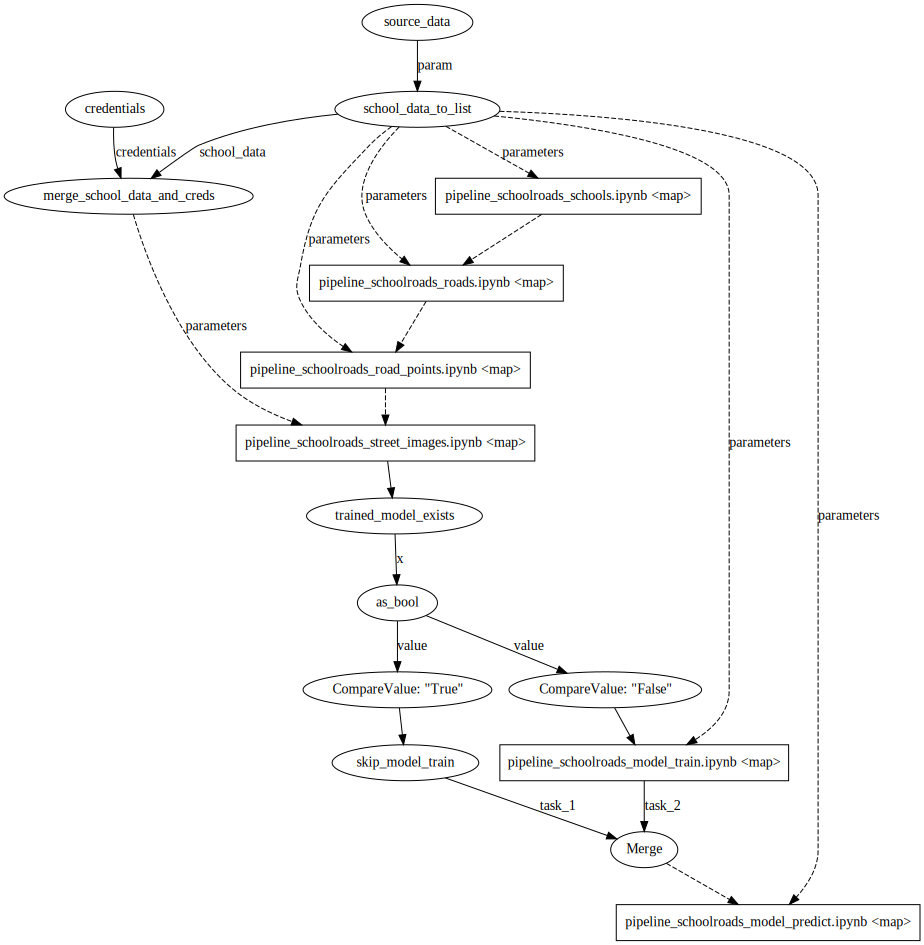

In [9]:
with Flow("pipeline_schoolroads") as flow:
    # location of school roads data sources
    sources = Parameter(
        "source_data",
        default="{}/config/pipeline_schoolroads_sources.yaml".format(os.getcwd()),
    )
    # note: credentials file excluded from repo as currently includes personal details
    credentials = Parameter(
        "credentials",
        default=Box.from_yaml(filename="../../pipeline_schoolroads_credentials.yaml"),
    )

    # prepare source data for mapping and a separate var for including credentials when necessary
    school_data = school_data_to_list(sources)
    school_data_and_creds = merge_school_data_and_creds(school_data, credentials)

    exe_notebook.name = "pipeline_schoolroads_schools.ipynb"
    source_data = exe_notebook.map(
        path=unmapped("pipeline_schoolroads_schools.ipynb"),
        output_format=unmapped(None),
        parameters=school_data,
        # exporter_kwargs=unmapped({"exclude_input": True, "exclude_output": True, "exclude_markdown": True})
    )

    exe_notebook.name = "pipeline_schoolroads_roads.ipynb"
    school_roads = exe_notebook.map(
        path=unmapped("pipeline_schoolroads_roads.ipynb"),
        parameters=school_data,
        upstream_tasks=[source_data],
    )

    exe_notebook.name = "pipeline_schoolroads_road_points.ipynb"
    school_road_points = exe_notebook.map(
        path=unmapped("pipeline_schoolroads_road_points.ipynb"),
        parameters=school_data,
        upstream_tasks=[school_roads],
    )

    exe_notebook.name = "pipeline_schoolroads_street_images.ipynb"
    school_road_images = exe_notebook.map(
        path=unmapped("pipeline_schoolroads_street_images.ipynb"),
        parameters=school_data_and_creds,
        upstream_tasks=[school_road_points],
    )

    exe_notebook.name = "pipeline_schoolroads_model_train.ipynb"
    school_road_images_model_train = exe_notebook.map(
        path=unmapped("pipeline_schoolroads_model_train.ipynb"), parameters=school_data,
    )

    ifelse(
        trained_model_exists(upstream_tasks=[school_road_images]),
        skip_model_train,
        school_road_images_model_train,
    )

    merged_train = merge(skip_model_train, school_road_images_model_train)

    exe_notebook.name = "pipeline_schoolroads_model_predict.ipynb"
    school_road_images_model_predict = exe_notebook.map(
        path=unmapped("pipeline_schoolroads_model_predict.ipynb"),
        parameters=school_data,
        upstream_tasks=[merged_train],
    )

flow.visualize()

In [ ]:
flow_state = flow.run()

In [ ]:
flow.visualize(flow_state=flow_state)